# Multiple local interpolation
For the Mandrill problem, since the missing data is fairly localized, using the entire matrix to fill the data can be wasteful. Instead of solving a large linear system, we believe that we can get a fairly reasonable reconstruction by solving smaller albeit more number of linear systems. We test the same on the Mandrill problem.

In [2]:
using Laplacians, LinearAlgebra, SparseArrays
using TestImages, Colors, Plots, FileIO, JLD

In [3]:
#Constructing the 2D Laplace matrix
function spdiagm_nonsquare(m, n, args...)
    I, J, V = SparseArrays.spdiagm_internal(args...)
    return sparse(I, J, V, m, n)
end

# returns -∇² (discrete Laplacian, real-symmetric positive-definite) on n₁×n₂ grid
function ∇²(n₁,n₂)
    o₁ = ones(n₁)
    ∂₁ = spdiagm_nonsquare(n₁+1,n₁,-1=>-o₁,0=>o₁)
    o₂ = ones(n₂)
    ∂₂ = spdiagm_nonsquare(n₂+1,n₂,-1=>-o₂,0=>o₂)
    return kron(sparse(I,n₂,n₂), ∂₁'*∂₁) + kron(∂₂'*∂₂, sparse(I,n₁,n₁))
end

∇² (generic function with 1 method)

In [4]:
img = testimage("mandrill");
imgg = Gray.(img);
mat = convert(Array{Float64}, imgg)[1:256,1:512];
# This image is square
#plot(imgg)
rows = size(mat,1);
columns = size(mat,2);
BoundaryNodes1 = collect(1:rows);
BoundaryNodes2 = collect(rows+1:rows:rows*columns-rows+1);
BoundaryNodes3 = collect(rows*columns-rows+2:rows*columns);
BoundaryNodes4 = collect(2*rows:rows:(columns-1)*rows);
BoundaryNodes= union(BoundaryNodes1, BoundaryNodes2, BoundaryNodes3, BoundaryNodes4);
AllNodes = collect(1:rows*columns)
NonBoundaryNodes = setdiff(AllNodes, BoundaryNodes);
size(NonBoundaryNodes);

# Adding holes to the Mandrill Image

In [5]:
cent = [(100, 200), (200, 100), (400, 200)]
c = cent[1]
rad = 20

L = 1:size(mat,1)
K = 1:size(mat,2)

mask = ones(size(mat))
mask = broadcast(+, (L .- c[1]).^2, (K .- c[2])'.^2) .> rad^2

keep = collect(1:prod(size(mat)))

fun(c, k) = filter(x -> (floor(x/size(mat,1)) .- c[1]).^2 + (x%size(mat,1) .- c[2])'.^2 > rad^2, k)

keep = fun(cent[1], keep)
keep = fun(cent[2], keep)
keep = fun(cent[3], keep)

prod(size(mask)) - sum(mask[keep]), 2*20^2*pi;

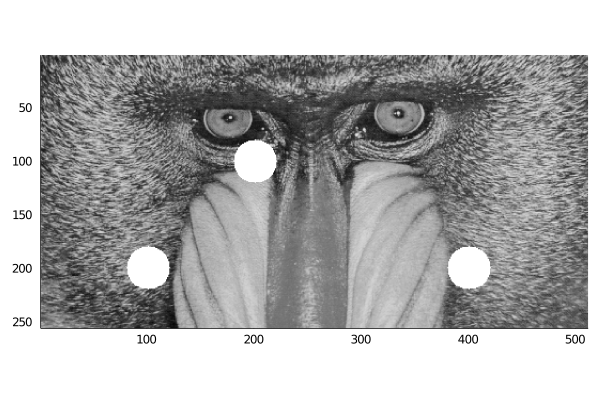

In [6]:
S = [i*size(mat,2)+j for i in 0:(size(mat,1)-1) for j in 1:size(mat,2)]
vals = mat[:]
holeyimage = ones(size(mat,1),size(mat,2))
holeyimage[S[keep]] = vals[keep]
plot(Gray.(holeyimage))

In [9]:
discard = setdiff(collect(1:prod(size(mat))), keep);

In [10]:
Circle1 = holeyimage[161:240, 61:140];
Circle2 = holeyimage[161:240, 361:440];
Circle3 = holeyimage[61:140, 161:240];
#plot(Gray.(Circle1))

In [12]:
AllNodes = collect(1:prod(size(Circle1)));
cent = [(40, 40)];
fun(c, k) = filter(x -> (floor(x/size(Circle1,1)) .- c[1]).^2 + (x%size(Circle1,1) .- c[2])'.^2 > rad^2, k)
keep = fun(cent[1], AllNodes);
discard = setdiff(AllNodes, keep)
rows = size(Circle1,1);
columns = size(Circle1,2)
A_C1  = ∇²(rows, columns);
C = sparse(I, rows*columns, rows*columns)
C[discard,discard] .= 0
Id = sparse(I, rows*columns,rows*columns);
f = Circle1[:];
@time u1 =((C-(Id -C)*A_C1)) \ (C*f);
restored_img1 = reshape(u1, size(Circle1,1), size(Circle1,2));
f = Circle2[:];
@time u2 =((C-(Id -C)*A_C1)) \ (C*f);
restored_img2 = reshape(u2, size(Circle1,1), size(Circle1,2));
f = Circle3[:];
@time u3 =((C-(Id -C)*A_C1)) \ (C*f);
restored_img3 = reshape(u3, size(Circle1,1), size(Circle1,2));

  0.006185 seconds (100 allocations: 5.128 MiB)
  0.006084 seconds (100 allocations: 5.128 MiB)
  0.005427 seconds (100 allocations: 5.128 MiB)


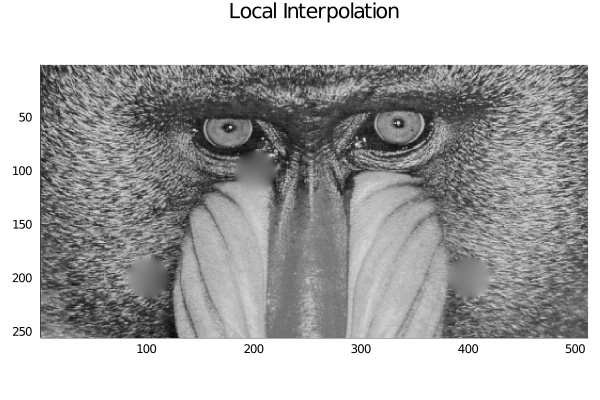

In [26]:
restored_img_multiple_inter = holeyimage;
restored_img_multiple_inter[161:240, 61:140] = restored_img1;
restored_img_multiple_inter[161:240, 361:440] = restored_img2;
restored_img_multiple_inter[61:140, 161:240] = restored_img3;
plot(Gray.(restored_img_multiple_inter), title="Local Interpolation")

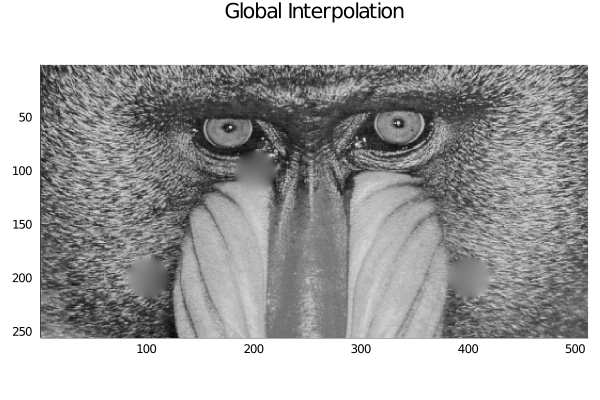

In [27]:
Mandrill_Holes_Restored_Global = load("Mandrill_Holes_Restored_Global.jld")["Mandrill_Holes_Restored_Global"];
Mandrill_Holes_Restored_Global = reshape(Mandrill_Holes_Restored_Global, size(mat,1), size(mat,2));
plot(Gray.(Mandrill_Holes_Restored_Global), title="Global Interpolation")

In [25]:
norm(restored_img_multiple_inter[:] - Mandrill_Holes_Restored_Global[:])

0.0